In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import random

In [2]:
# Always reset the pseudo random number generator to the same number.
seed = 2
np.random.seed(seed)
random.seed(seed)

### Definição de funções úteis.

In [3]:
def calculateErrorSurface(y, x1, x2):
    '''Generate data points for plotting the error surface.'''

    # Generate values for parameter space.
    M = 200
    a1 = np.linspace(-12.0, 14.0, M)
    a2 = np.linspace(-12.0, 14.0, M)

    A1, A2 = np.meshgrid(a1, a2)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M,M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
            J[iter1][iter2] = (1.0/len(y))*np.sum(np.square(y - yhat))           
            
    return J, A1, A2

# learning schedule: Temporal decay.
def timeBasedDecay(alpha_init, k, t):
    '''Temporal decay.'''
    return alpha_init / (1.0 + k*t)

# learning schedule: Exponential decay.
def exponentialDecay(alpha_init, k, t):
    '''Exponential decay.'''
    return alpha_init * np.exp(-k*t)

# learning schedule: Gradual decay.
def stepDecay(alpha_init, t, epochs_drop=8.0):
    '''Gradual decay.'''
    drop = 0.5
    alpha = alpha_init * math.pow(drop, math.floor((1+t)/epochs_drop))
    return alpha

def learning_schedule(typels, alpha_init, k, t):
    '''Funtion used to choose among some learning schedules'''
    if(typels=='exp'):
        alpha = exponentialDecay(alpha_init, k, t)
    elif(typels=='time'):
        alpha = timeBasedDecay(alpha_init, k, t)
    elif(typels=='step'):
        alpha = stepDecay(alpha_init, t)
    else:
        alpha = alpha_init
    return alpha

# Gradiente descendente estocástico.
def gradientDescent(X, y_noisy, n_epochs, N, alpha_init, k, lrschedule='None', seed=42):
    '''Function implementing the stochastic version of the gradient descent'''

    # Reset the PN sequence generator.
    random.seed(seed)
    
    # Initialization of parameters.
    a = np.array([-10.0, -10.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*N+1))
    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create vector to store eta history.
    alpha_hist = np.zeros((n_epochs*N))

    update_prev = np.zeros((2, 1))

    # Create array for storing error values.
    Jgd = np.zeros(n_epochs*N+1)

    Jgd[0] = (1.0/N)*sum(np.power(y_noisy - X.dot(a), 2))

    update_hist = np.zeros((2, n_epochs*N))

    gradient_hist = np.zeros((2, n_epochs*N))

    # Stocastic gradient-descent loop.
    iteration = 0
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_data_set_indexes = random.sample(range(0, N), N)    

        for i in range(N):
            # Select ONE pair sample/label from the dataset.
            random_index = shuffled_data_set_indexes[i]
            xi = X[random_index:random_index+1]
            yi = y_noisy[random_index:random_index+1]

            # Select the learning rate.
            alpha = learning_schedule(lrschedule, alpha_init, k, epoch*N + i)

            # Update the weights.
            gradient = -2.0*xi.T.dot(yi - xi.dot(a))
            update = alpha*gradient
            a = a - update

            # Store current values.
            a_hist[:, epoch*N+i+1] = a.reshape(2,)
            alpha_hist[epoch*N+i] = alpha
            update_hist[:, epoch*N+i] = update.reshape(2,)
            gradient_hist[:, epoch*N+i] = gradient.reshape(2,)

            # Calculate error for current iteration.
            Jgd[epoch*N+i+1] = (1.0/N)*sum(np.power((y_noisy - X.dot(a)), 2))
            
            iteration = epoch*N+i
            
    return a, Jgd, a_hist, alpha_hist, update_hist, gradient_hist, iteration

### Gerando a função observável.

$$y = a_1 x_1 + a_2 x_2,$$
onde $a_1$ e $a_2$ são iguais a 1 e $x_1$ e $x_2$ são valores retirados da distribuição Gaussiana Normal Padrão.

$$y_{noisy} = y + w,$$
onde $w$ é o ruído adicionado às amostras e segue a distribuição Gaussiana Normal Padrão.

A função hipótese que será usada é dada por
$$h(x) = \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

In [4]:
# Define the number of examples.
N = 1000

# Features.
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2 

# Observable function.
y_noisy = y + w

### Plotando a função observável.

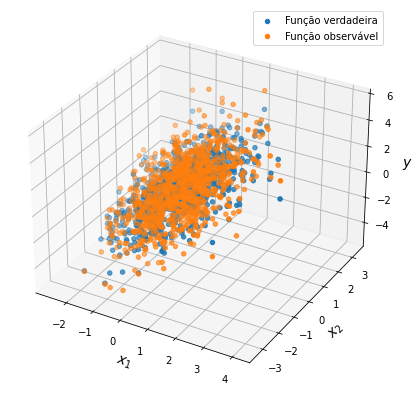

In [5]:
# Plot observable function.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()

ax.scatter(x1,x2,y, label='Função verdadeira')
ax.scatter(x1,x2,y_noisy, label='Função observável')
ax.set_xlabel('$x_1$', fontsize=14)
ax.set_ylabel('$x_2$', fontsize=14)
ax.set_zlabel('$y$', fontsize=14)
plt.legend()
plt.show()

### Encontrando a solução ótima com a equação normal.

In [6]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

# Print a1 and a2 weights.
print('peso a1:', a_opt[0][0])
print('peso a2:', a_opt[1][0])

# Perform prediction.
yhat = X.dot(a_opt)

# Calculate the mean squared error.
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

# Plot the MSE.
print('Erro:', Joptimum)

peso a1: 0.98225721822437
peso a2: 1.0387421041101117
Erro: 1.062891923320523


### Plotando a superfície de erro.

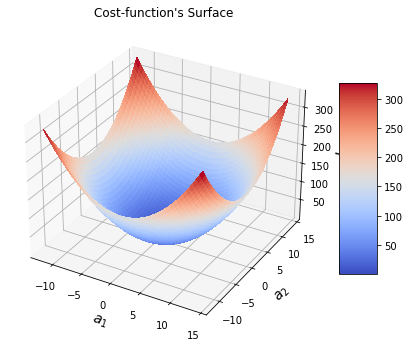

In [7]:
J, A1, A2 = calculateErrorSurface(y_noisy, x1, x2)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#plt.savefig("error_surface_sgd_ls.png", dpi=600)
#Show the plot.
plt.show()

### Encontrando os pesos com o gradiente descendente.

In [8]:
# Number of epochs.
n_epochs = 1

#lrschedule = 'none'
lrschedule = 'step'

# Constant learning rate.
alpha_init = 0.1

# Decay rate.
k = 0.01

# Gradient-descent solution.
a, Jgd, a_hist, alpha_hist, update_hist, gradient_hist, iteration = gradientDescent(X, y_noisy, n_epochs, N, alpha_init, k, lrschedule, seed)

### Plotando a superfície de contorno

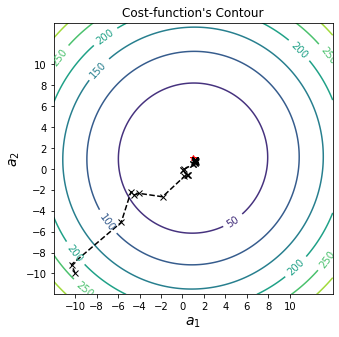

In [9]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 12, step=2.0))
plt.yticks(np.arange(-10, 12, step=2.0))
plt.savefig("error_contour_sgd_ls.png", dpi=600)
plt.show()

### Comparando os valores dos pesos.

In [10]:
# Print found values.
print('a1_opt: ' + str(a_opt[0, 0]))
print('a2_opt: ' + str(a_opt[1, 0]))
print('')

print('a1_sgd: ' + str(a[0, 0]))
print('a2_sgd: ' + str(a[1, 0]))

a1_opt: 0.98225721822437
a2_opt: 1.0387421041101117

a1_sgd: 1.1339333174411281
a2_sgd: 0.8229800783478779


### Plotando a variação do passo de aprendizagem.

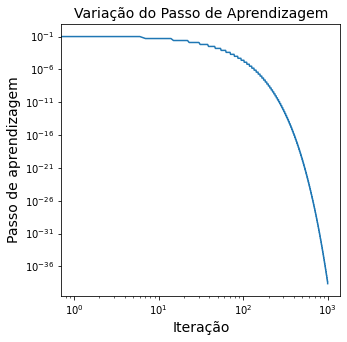

In [11]:
# Plot alpha history     
fig = plt.figure(figsize=(5,5))
plt.plot(range(0,n_epochs*N), alpha_hist)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Iteração', fontsize=14)
plt.ylabel('Passo de aprendizagem', fontsize=14)
plt.title('Variação do Passo de Aprendizagem', fontsize=14)
plt.savefig("passo_de_aprendizagem_gradual.png", dpi=600)
plt.show()

### Plotando MSE em função das iterações.

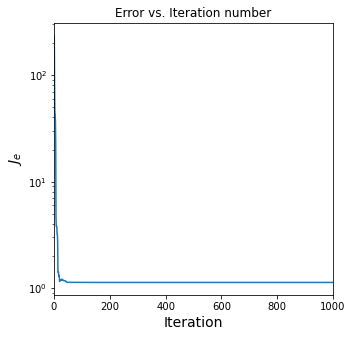

In [12]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, n_epochs*N), Jgd[0:n_epochs*N])
plt.xlim((0, n_epochs*N))
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
#plt.savefig("error_vs_iteration_sgd_ls.png", dpi=600)
plt.show()

### Plotando a variação do gradiente ao longo das iterações.

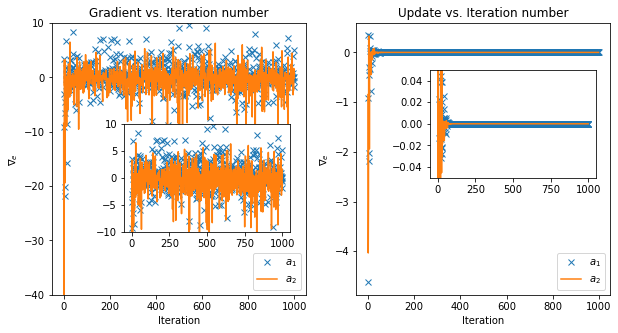

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.plot(np.arange(0, n_epochs*N), gradient_hist[0,:], 'x', label='$a_1$')
ax1.plot(np.arange(0, n_epochs*N), gradient_hist[1,:], label='$a_2$')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iteration number')
ax1.set_ylim(-40,10)
ax1.legend()

ax2.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'x', label='$a_1$')
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], label='$a_2$')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Update vs. Iteration number')
ax2.legend()

left, bottom, width, height = [0.225, 0.3, 0.23, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot(np.arange(0, n_epochs*N), gradient_hist[0,:], 'x')
ax3.plot(np.arange(0, n_epochs*N), gradient_hist[1,:])
ax3.set_ylim(-10,10)

left, bottom, width, height = [0.65, 0.45, 0.23, 0.3]
ax4 = fig.add_axes([left, bottom, width, height])
ax4.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'x')
ax4.plot(np.arange(0, n_epochs*N), update_hist[1,:])
ax4.set_ylim(-0.05, 0.05)

plt.show()